# Elastix parameters explanation

This library can be seen as one big wrapper of [SimpleElastix](https://simpleelastix.github.io/), which is a well established library for performing medical image registration. Elastix is built on top of [SimpleITK](https://simpleitk.org/), another module for registration, but that does not include automatic parameter estimation. 

At the heart of each of those libraries are several [fundamental concepts](https://simpleitk.readthedocs.io/en/master/fundamentalConcepts.html) that should be thoroughly understood. Each library is attempting to achieve the same thing: treat image registration as an optimisation problem, and perturb a moving image via some parameters such that it's difference to the fixed is minimized. Thus some issues arise with parameter estimation: each image needs a different learning rate for its optimizer, defining the intial alignment to then perform optimizaiton form, and so forth. 

Elastix takes care of this for us using a number of methods. I reccomend reading the [libray's manual](https://elastix.lumc.nl/download/elastix-5.0.1-manual.pdf) in thorough detail as it focuses very little on implementation but rather on the motivations for many of these steps, along with citations for the papers that established these methods. 

With that said let's take a look at how the learning rate and similarity metric changes across optimizer iterations from the results in the first notebook.

In [1]:
from exm.io.io import parseSitkLog
metric, lr = parseSitkLog('./sitk_log/elastix.log')

Text(0, 0.5, 'Mutual Informatiton')

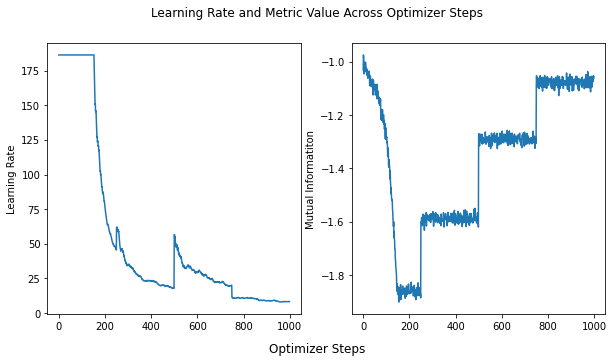

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle('Learning Rate and Metric Value Across Optimizer Steps')
fig.supxlabel('Optimizer Steps')

ax[0].plot(lr)
ax[0].set_ylabel('Learning Rate')

ax[1].plot(metric)
ax[1].set_ylabel('Mutual Informatiton')

Note that each discrete jump you see is due to a change in resolution, where depending on the image pyramid you define the first resolution we see here is a heavily downsampled image, thus causing the registration to only focus on coarse 3D structures. So each reoslution is given 250 iterations to find optimal parameters, and in the end Elastix returns the parameters that minimizes the cost function. 

The number of optimizer iterations, similarity metric used, type of transform used, and many other parameters are all configruable by the user. The default parameters for the current pipeline can be found under `exm/config/default.py`, and this is primarily used for defining the parameter map you will then pass to Elastix to perform registration. 

In [14]:
from exm.config.utils import load_cfg
from exm.align.build import alignBuild
#load deafult params
cfg = load_cfg()
#pass to alignBuild and print parameter map
align = alignBuild(cfg)
print(align.parameter_map)

None


Of course it is none, we need to define it first!

In [23]:
pmap = align.createParameterMap()

print(pmap.items())

[('AutomaticParameterEstimation', ('true',)), ('AutomaticScalesEstimation', ('true',)), ('CheckNumberOfSamples', ('true',)), ('DefaultPixelValue', ('0.0',)), ('FinalBSplineInterpolationOrder', ('1',)), ('FixedImagePyramid', ('FixedSmoothingImagePyramid',)), ('ImageSampler', ('RandomCoordinate',)), ('Interpolator', ('LinearInterpolator',)), ('MaximumNumberOfIterations', ('2000',)), ('MaximumNumberOfSamplingAttempts', ('100',)), ('Metric', ('AdvancedMattesMutualInformation',)), ('MovingImagePyramid', ('MovingSmoothingImagePyramid',)), ('NewSamplesEveryIteration', ('true',)), ('NumberOfResolutions', ('4',)), ('NumberOfSamplesForExactGradient', ('100000',)), ('NumberOfSpatialSamples', ('2048',)), ('Optimizer', ('AdaptiveStochasticGradientDescent',)), ('Registration', ('MultiResolutionRegistration',)), ('ResampleInterpolator', ('FinalBSplineInterpolator',)), ('Resampler', ('DefaultResampler',)), ('ResultImageFormat', ('nii',)), ('Transform', ('EulerTransform',)), ('WriteIterationInfo', ('fa

Each of these are important in their own right, the defaults work decently well, but sometimes you might want to change the `MaximumNumberOfIterations` to something smaller like 250 if you know that the registration problem is easily solvable, or other times you might want to use only a single resolution registration scheme. It is up to you how you want to configure your registration scheme.

There are also a number of parameters related to 